
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- **This is an individual homework. No group collaboration.**
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import OLS
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw4.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.


**1.3** Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.

Plot two histograms ofyour best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.

Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.


**1.4** Using your top gene from the previous part (call it  `best_predictor`), create a classification model by manually eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.

<hr> <hr>

<hr>
### Solutions

**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [4]:
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))

(752, 7130)
(601, 7129) (151, 7129) (601,) (151,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.**


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


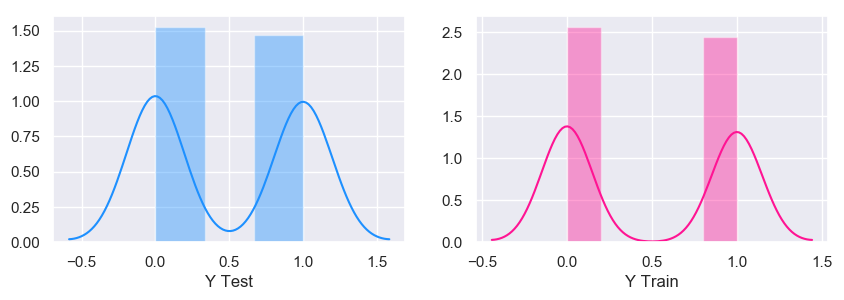

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=100)
sns.distplot(y_test , color="dodgerblue", ax=axes[0], axlabel='Y Test')
sns.distplot(y_train , color="deeppink", ax=axes[1], axlabel='Y Train')


In [6]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,-115.860969,-160.846155,26.545301,209.733439,-248.992903,-405.422569,-24.135140,-188.491329,74.777098,97.436777,...,161.766492,707.377318,4.198787,421.466477,-50.023954,819.053113,329.803212,8.803791,507.250039,-24.377549
std,170.571929,188.676919,207.781982,202.987246,207.328054,261.112412,535.143398,163.077167,174.693115,358.897719,...,165.152970,526.644408,152.401188,589.914084,106.864078,814.898058,367.788891,85.397644,939.394188,71.102874
min,-894.789505,-1095.737090,-645.439001,-425.750627,-1154.285694,-1091.492494,-2066.516448,-728.996262,-770.025847,-1176.663615,...,-501.285884,-1010.430536,-447.077819,-1870.955269,-432.967768,-2151.593119,-651.051441,-255.419724,-2754.665185,-237.864216
25%,-222.586579,-270.502055,-95.000000,85.327810,-379.048622,-567.547758,-338.435164,-302.872287,-20.739507,-117.000000,...,67.861184,361.596510,-88.660905,88.409441,-105.000000,270.198265,90.825501,-40.391630,-50.785999,-73.000000
50%,-105.139096,-145.829450,21.183690,207.291048,-231.007621,-433.214742,-39.581881,-175.586059,90.170754,101.975176,...,153.253301,679.935520,9.960900,381.000000,-35.000000,749.281111,296.978609,7.968505,407.942117,-25.403427
75%,-4.789696,-40.599329,127.821586,331.277808,-116.000000,-252.587379,325.000000,-74.379003,190.551199,288.503617,...,263.112797,1076.075567,96.051876,720.339588,19.775025,1286.343005,521.096719,62.794411,1092.430279,19.740635
max,516.618491,384.626762,748.233182,1022.560525,308.876677,607.737258,1385.881293,263.634029,589.778466,1355.537180,...,686.321597,2522.188808,481.820516,3982.980299,215.047697,3743.264860,1996.244626,274.575647,3315.374276,224.773440


In [7]:
X_train_array = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_train_array)
normalized_X_train = pd.DataFrame(x_scaled)
normalized_X_train.columns = X_train.columns

In [8]:
normalized_X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,0.551880,0.631528,0.482168,0.438776,0.618723,0.403753,0.591583,0.544518,0.621268,0.503159,...,0.558309,0.486270,0.485819,0.391604,0.590949,0.503939,0.370512,0.498539,0.537380,0.461455
std,0.120852,0.127453,0.149090,0.140154,0.141699,0.153665,0.155006,0.164288,0.128469,0.141734,...,0.139064,0.149080,0.164067,0.100772,0.164910,0.138239,0.138930,0.161129,0.154759,0.153690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.476264,0.557454,0.394956,0.352879,0.529837,0.308342,0.500545,0.429288,0.551025,0.418475,...,0.479238,0.388388,0.385852,0.334709,0.506111,0.410831,0.280240,0.405717,0.445447,0.356357
50%,0.559477,0.641672,0.478321,0.437090,0.631015,0.387398,0.587109,0.557519,0.632589,0.504952,...,0.551141,0.478502,0.492022,0.384691,0.614133,0.492102,0.358113,0.496963,0.521019,0.459238
75%,0.630576,0.712756,0.554837,0.522697,0.709618,0.493697,0.692712,0.659477,0.706408,0.578614,...,0.643646,0.590640,0.584703,0.442659,0.698660,0.583209,0.442772,0.600409,0.633784,0.556818
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.**

**Answer:**
The large dimensionality can mean that some of the columns may be related to the outcome variable by luck, rather than any kind of causal relationship. 

**1.3** **Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.**

**Plot two histograms of your best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.**

**Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.**

In [9]:
t_test_results = {}
AML = normalized_X_train.where(y_train== 1).dropna()
ALL = normalized_X_train.where(y_train== 0).dropna()


for x in normalized_X_train.columns:
    AML2 = AML[:][x]
    ALL2 = ALL[:][x]
    t_test_results[x] = scipy.stats.ttest_ind(AML2,ALL2)

In [10]:
t_test_train_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
t_test_train_df.columns = ['field','pvalue']
t_test_train_df=t_test_train_df.sort_values('pvalue').head(10)

In [11]:
top_10_pred = t_test_train_df.head(10).index
top_10_pred

Index(['D26067_at', 'X87160_at', 'J05401_at', 'L13744_at', 'M81650_rna1_at',
       'J00220_cds4_at', 'Z46632_r_at', 'U83411_at', 'HG2090-HT2152_s_at',
       'M17446_s_at'],
      dtype='object')

In [12]:
top_pred = t_test_train_df.head(1).index
print(top_pred)

Index(['D26067_at'], dtype='object')


Text(0.5, 0, 'D26067_at Gene')

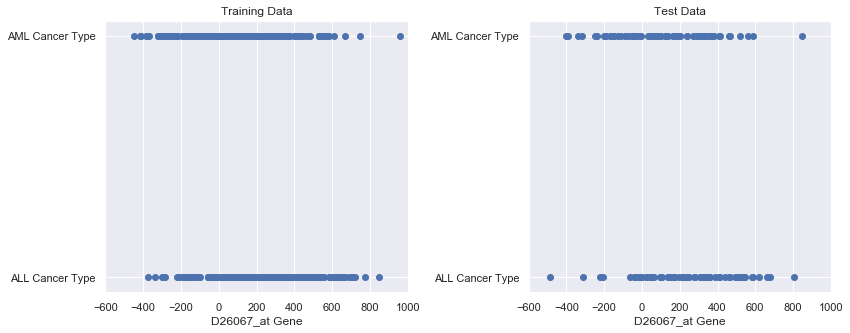

In [13]:
fig = plt.figure(figsize=(13, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(1, 2,1)
plt.scatter(X_train[top_pred],y_train)
plt.title("Training Data")
plt.xlim(-600,1000)
plt.xlabel("D26067_at Gene")
plt.yticks([0,1],['ALL Cancer Type','AML Cancer Type'])



plt.subplot(1,2,2)
plt.scatter(X_test[top_pred],y_test)
plt.title("Test Data")
plt.xlim(-600,1000)
plt.yticks([0,1],['ALL Cancer Type','AML Cancer Type'])
plt.xlabel("D26067_at Gene")



**1.4 Using your top gene from the previous part (call it  `best_predictor`), create a classification model by eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.**


It is a bit disconcerting that the test and training trends don't follow each other too closely, but there appears to be a common around 325. 

Given that, I would say that if the D26067_at gene is above 325 then I would think the person has ALL type of cancer. Below 325 and they would likely have AML type of cancer.

<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>


In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor that you identify as the best predictor above to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML). Is there a problem with this interpretation?


Create a figure with following items displayed on the same plot (use training data):
 - the predicted quantitative response from the linear regression model as a function of the best gene predictor
 - the true binary response. 


**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.


**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 


**2.4** 
Print and interpret the logistic regression coefficients: the 'slope' and intercept. 


Create 2 plots (one each for training and testing data) with 4 items displayed on each plot.
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



<hr>
### Solutions

**2.1** **Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML).  Is there a problem with this interpretation?**



In [14]:
# your code here
# training set

x_train_padded = sm.add_constant(X_train[top_pred]) # to allow for beta_0
y_train_lr = y_train.values.reshape(-1,1)


model = OLS(y_train_lr, x_train_padded)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     53.44
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           8.58e-13
Time:                        21:51:29   Log-Likelihood:                -410.33
No. Observations:                 601   AIC:                             824.7
Df Residuals:                     599   BIC:                             833.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5948      0.024     24.317      0.000       0.547       0.643
D26067_at     -0.0006   8.55e-05     -7.310      0.000      -0.001      -0.000
==============================================================================
Omnibus:                        0.325   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.850   Jarque-Bera (JB):               70.414
Skew:                           0.056   Prob(JB):                     5.13e-16
Kurtosis:                       1.327   Cond. No.                         358.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Yes, the linear regression model may give probabilities above 1 or below 0, which would not make much intuitive sense (and also would not mean a guarantee that you do or do not have that type of cancer)

**2.2** **Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.**

In [15]:
y_hat_train_lin = results.predict(exog=x_train_padded)

# development set
x_dev_padded = sm.add_constant(X_test[top_pred])
y_dev_lr = y_test.values.reshape(-1,1)

y_hat_test_lin = results.predict(exog=x_dev_padded)

print("Training accuracy: ", str(accuracy_score(y_train, np.round(y_hat_train_lin))))
print("Test accuracy: ", str(accuracy_score(y_test, np.round(y_hat_test_lin))))


Training accuracy:  0.6206322795341098
Test accuracy:  0.5894039735099338



**2.3** **Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Are the classifications substantially different?  Explain why this is the case.**

**Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').

In [16]:
lr = LogisticRegression(C=100000000)
lr.fit(X_train[top_pred], y_train)

y_hat_train_log = lr.predict(X_train[top_pred])
print("Training Accuracy:", accuracy_score(y_train, y_hat_train_log))

y_hat_test_log = lr.predict(X_test[top_pred])
print("Test Accuracy:", accuracy_score(y_test, y_hat_test_log))

Training Accuracy: 0.6173044925124792
Test Accuracy: 0.5894039735099338


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Answer:** 
The training accuracy is a little bit worse and the test accuracy is the same. You might expect this because we are only using one variable, so there isn't likely to be a lot of variation between the different models.

**2.4 Print and interpret the logistic regression coefficients: the 'slope' and the intercept.**

**Create 2 plots (with training and test data) with 4 items displayed on each plot.**
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$.

**Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer.** 


(-600, 1000)

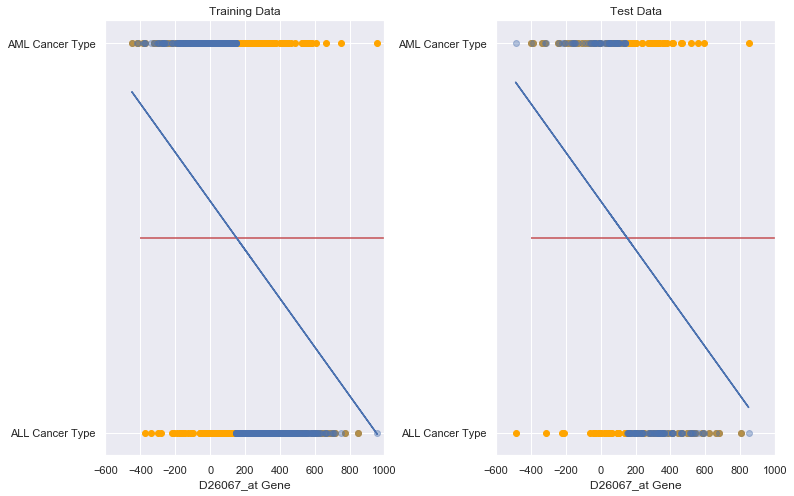

In [17]:
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(1, 2,1)
plt.scatter(X_train[top_pred],y_train,alpha=1,color='orange')
plt.plot(X_train[top_pred],y_hat_train_lin)
plt.scatter(X_train[top_pred],y_hat_train_log,alpha = 0.4)
plt.hlines(xmin=-400,xmax=1000,y=0.5,color='r')


plt.title("Training Data")
plt.xlim(-600,1000)
plt.xlabel("D26067_at Gene")
plt.yticks([0,1],['ALL Cancer Type','AML Cancer Type'])


plt.subplot(1,2,2)
plt.scatter(X_test[top_pred],y_test,alpha=1,color='orange')
plt.plot(X_test[top_pred],y_hat_test_lin)
plt.scatter(X_test[top_pred],y_hat_test_log,alpha = 0.4)
plt.hlines(xmin=-400,xmax=1000,y=0.5,color='r')
plt.yticks([0,1],['ALL Cancer Type','AML Cancer Type'])
plt.xlabel("D26067_at Gene")


plt.title("Test Data")
plt.xlim(-600,1000)

To the naked eye, they both look exactly the same, except the linear follows a slightly different path than the logistic. However, after we incorporate the cutoff after creating our predictions, I would expect a very similar result between the two models. Frankly, I'm a bit surprised the linear performed better for the training -- I would have thought they would have the same exact accuracy just like on the test dataset. 

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  


**3.3** Comment on the classification accuracy of training and test set? Given the results above how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole? 

**3.4** Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.

**3.5** Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).

<hr>
### Solutions

**3.1** **Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?**  


In [18]:
lr = LogisticRegression(C=100000000)
lr.fit(X_train, y_train)

y_hat_train_log = lr.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_hat_train_log))

y_hat_test_log = lr.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_hat_test_log))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Accuracy: 1.0
Test Accuracy: 0.7417218543046358


**Answer:**
With all of the variables, we were able to completely fit the training data (not necessarily a good thing), and were able to get test accuracy up to 74%. This is a significant improvement, even if we are likely overfitting to our training dataset.

**3.2** **How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.**

**Hint:** **To answer this question, use *bootstrapping* with 1000 bootstrap samples/iterations.**  


In [19]:
import warnings
warnings.filterwarnings("ignore")

coefficients = pd.DataFrame()

for x in range(0,1000):
    sample_index = np.random.choice(range(0, len(y_train)), len(y_train))

    X_samples = X_train.iloc[sample_index]
    y_samples = y_train.iloc[sample_index]    

    lr = LogisticRegression(C=100000000)
    lr.fit(X_samples, y_samples)
    coefficients = pd.concat([coefficients,pd.DataFrame(lr.coef_)])
    
coefficients.columns = X_train.columns

In [20]:
from scipy.stats import ttest_1samp

bootstrap_ttest = pd.DataFrame(columns = ['Field','Tset','P Value'])
for col in coefficients.columns:
    tset, pval = ttest_1samp(coefficients[col], 0)
    bootstrap_ttest=pd.concat([bootstrap_ttest,pd.DataFrame({'Field':col,
                                                             'Tset':tset,
                                                            'P Value':pval},
                                                           index=[0])
                              ])

In [21]:
significant_vals = bootstrap_ttest.loc[bootstrap_ttest['P Value']<0.05]
print(len(significant_vals)," variables are significantly different from 0 at 5% significance level")

6799  variables are significantly different from 0 at 5% significance level


**3.3 Open question: Comment on the classification accuracy of training and test set? Given the results above how would you assest the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole.**

**Answer:** 
Our logistic regression model was able to completely fit the dataset, which can be expected when there are more predictors than there are observations. This probably isn't a good thing. I think it would be a good idea to either bootstrap or find some way to remove features that might be extra noise for our dataset. We should aim to have less features than we have observations to avoid a perfect fit on the training data. If this isn't possible we can do a lot of bootstrapping to help as well. 

In terms of other tests, we could remove ~10% of our training data to create a validation group to help us understand the accuracy of the model before we look at the actual test data. 

**3.4 Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.**

In [22]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

lasso = Lasso(random_state=0, max_iter=10000)
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [33]:
coef_dict = {}
for coef, feat in zip(model_lasso.coef_,X_train.columns):
    coef_dict[feat] = coef


In [35]:
y_hat_test_lasso = model_lasso.predict(X_test)
y_hat_train_lasso = model_lasso.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, np.round(y_hat_train_lasso)))
print("Test Accuracy:", accuracy_score(y_test, np.round(y_hat_test_lasso)))
print("Lasso picked " + str(sum(model_lasso.coef_ != 0)) + " variables and eliminated the other " +  str(sum(model_lasso.coef_ == 0)) + " variables")


Training Accuracy: 1.0
Test Accuracy: 0.6821192052980133
Lasso picked 593 variables and eliminated the other 6536 variables


**3.5: Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).**

In [38]:
for x in top_10_pred:
    print(x,": ",coef_dict[x])

D26067_at :  0.0
X87160_at :  -0.0
J05401_at :  -0.0
L13744_at :  -0.0
M81650_rna1_at :  0.0
J00220_cds4_at :  -0.0
Z46632_r_at :  -3.2066587099027466e-07
U83411_at :  0.0
HG2090-HT2152_s_at :  0.0
M17446_s_at :  0.0


**Answer:**
The lasso regression made 9 of the top 10 predictors into non-factors for the final model. This suggests that the variables were not the best at differentiating the cancer types. It is interesting to note that almost all of the features showed a statistically significant coefficient when running the logistic regression bootstrapping model.

<div class='exercise'> <b> Question 4 [25pts]: Multi Class Log Regression </b> </div>

**4.1** Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset? 

**4.2** Split the dataset into train and test, 80-20 split, random_state = 8. 

We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using the training dataset.  It should be easily discernable via labeling/marking in the plot which observations belong to which `cancer_type`.

**4.3** Fit the following two models using crossvalidation: 
- Logistic Regression Multiclass model with linear features. 
- Logistic Regression Multiclass model with Polynomial features, degree = 2.

**4.4** Plot the decision boundaries for each model and interpret the results. Hint: You may utilize the function `overlay_decision_boundary`. 

**4.5** Report and plot the CV scores for the two models and interpret. 


<hr>
### Solutions

**4.1 Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset?**

In [39]:
mc_enhance = pd.read_csv("./data/hw4_mc_enhance.csv",index_col=0)

In [40]:
mc_enhance.shape

(750, 7130)

In [41]:
mc_enhance.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,-1014.598658,-1048.357272,-823.358695,-315.636838,-1295.949886,-1625.120199,-826.955064,-1175.612555,-588.598064,-534.924646,...,812.768978,-747.263549,16.272227,-801.847334,1031.081628,-3.162310,-723.364564,-40.495922,-810.150889,1.000000
std,297.369331,233.933609,392.662256,215.534283,320.799277,419.687380,562.688520,288.546511,227.362605,489.552685,...,663.320928,176.481127,751.988770,157.068732,966.569338,495.241653,138.805059,882.681724,176.347552,0.817041
min,-2010.202020,-1772.451092,-1619.756151,-930.821077,-1984.530972,-2514.619404,-2766.759937,-1725.591441,-1255.146509,-1552.135008,...,-375.241836,-1484.465401,-853.838447,-1367.829068,-571.900054,-838.747726,-1162.232820,-1266.486530,-1298.638023,0.000000
25%,-1141.429466,-1218.887728,-1076.151552,-454.824979,-1548.108060,-1848.322368,-1203.978707,-1371.756006,-718.014815,-853.188715,...,322.566010,-847.468558,-335.783011,-924.099294,337.355440,-356.629007,-820.617263,-435.750013,-933.182073,0.000000
50%,-1033.862143,-1024.510062,-896.612263,-255.321214,-1257.060242,-1701.504007,-875.340089,-1138.486182,-586.848142,-554.578969,...,639.993676,-750.170322,-130.115409,-783.870080,777.827303,-180.519462,-733.242628,-261.276132,-816.239345,1.000000
75%,-837.607536,-885.604686,-560.246417,-196.687009,-1092.191607,-1259.153655,-508.663556,-978.433566,-416.287415,-173.861061,...,1355.814050,-654.438425,117.823076,-706.793736,1571.382500,209.283781,-609.175359,36.278669,-708.453545,2.000000
max,-385.768608,-477.363374,130.829434,257.521293,-304.800847,-850.745403,929.737460,-466.326738,196.149024,988.039921,...,2482.375600,-230.208352,5082.744968,-428.086002,4221.275650,1363.790953,-427.657222,5845.204223,-268.531949,2.000000


In the enhanced data, there are 3 classes of cancer type (0,1,2)

**4.2 Split the dataset into train and test, 80-20 split, random_state = 8.**

**We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using training dataset.  We should be able to discern from the plot which sample belongs to which `cancer_type`.** 

In [42]:
X_train2, X_test2, y_train2, y_test2 =train_test_split(mc_enhance.loc[:, mc_enhance.columns != 'cancer_type'], 
                                                         mc_enhance.cancer_type, test_size=0.2, 
                                                         random_state = 8, 
                                                         stratify = mc_enhance.cancer_type)

Text(0.5, 0, 'Cancer Type')

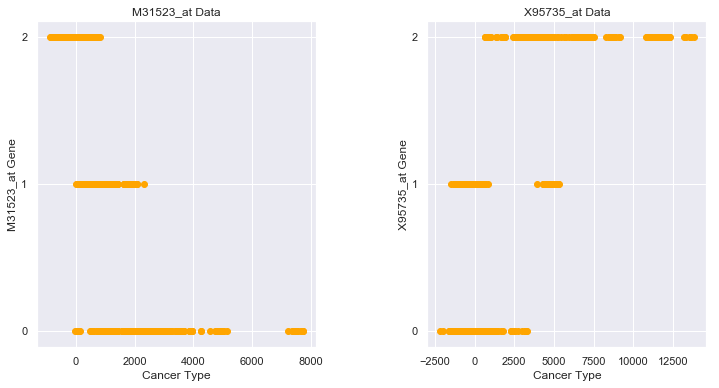

In [43]:
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(1, 2,1)
plt.scatter(X_train2['M31523_at'],y_train2,alpha=1,color='orange')

plt.title("M31523_at Data")
plt.ylabel("M31523_at Gene")
plt.xlabel("Cancer Type")
plt.yticks([0,1,2])


plt.subplot(1,2,2)
plt.scatter(X_train2['X95735_at'],y_train2,alpha=1,color='orange')
plt.yticks([0,1,2])

plt.title("X95735_at Data")
plt.ylabel("X95735_at Gene")
plt.xlabel("Cancer Type")

**4.3  Fit the following two models using crossvalidation:**

**Logistic Regression Multiclass model with linear features.**

**Logistic Regression Multiclass model with Polynomial features, degree = 2.**


In [44]:
X_train2_subset = X_train2[['M31523_at','X95735_at']]
X_test2_subset = X_test2[['M31523_at','X95735_at']]

In [45]:
from sklearn import linear_model

mc_enhance_logistic_model = linear_model.LogisticRegressionCV(cv=5,multi_class='multinomial', 
                                     random_state=8).fit(X_train2_subset,
                                                                  y_train2)

In [47]:
X_train2_subset_poly=X_train2_subset
X_train2_subset_poly['M31523_at'] = X_train2_subset['M31523_at']**2
X_train2_subset_poly['X95735_at'] = X_train2_subset['X95735_at']**2

In [48]:
mc_enhance_poly_logistic_model = linear_model.LogisticRegressionCV(cv=5,multi_class='multinomial', 
                                     random_state=8).fit(X_train2_subset_poly, y_train2)

**4.4 Plot the decision boundary and interpret results. Hint: You may utilize the function `overlay_decision_boundary`** 


In [49]:
mc_enhance_poly_logistic_model.predict

<bound method LinearClassifierMixin.predict of LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=8, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)>

In [50]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, 
                              ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X)
    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

Logistic Multinomial Regression Decision Overlay Graph


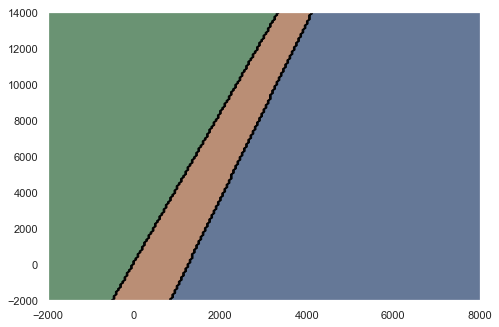

In [51]:
print("Logistic Multinomial Regression Decision Overlay Graph")
overlay_decision_boundary(ax=plt.axes([1,1,1,1], projection=None, polar=False), 
                              model=mc_enhance_logistic_model, colors=None, nx=200, 
                              ny=200, desaturate=.5, xlim=[-2000,8000], ylim=[-2000,14000])

Polynomial Logistic Multinomial Regression Decision Overlay Graph


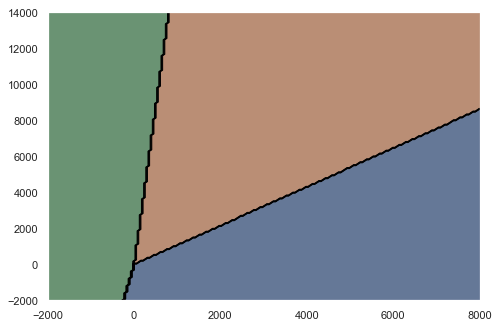

In [52]:
print("Polynomial Logistic Multinomial Regression Decision Overlay Graph")
overlay_decision_boundary(ax=plt.axes([1,1,1,1], projection=None, polar=False), 
                              model=mc_enhance_poly_logistic_model, colors=None, nx=200, 
                              ny=200, desaturate=.5, xlim=[-2000,8000], ylim=[-2000,14000])

**4.5 Report and plot the CV scores for the two models and interpret.**

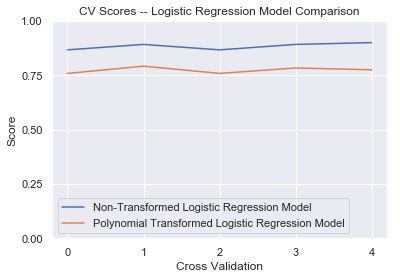

In [53]:
cv_scores_poly = []
cv_scores = []

for x in mc_enhance_poly_logistic_model.scores_[0]:
    cv_scores_poly.append(x[0])

for x in mc_enhance_logistic_model.scores_[0]:
    cv_scores.append(x[0])


plt.plot(cv_scores,label = "Non-Transformed Logistic Regression Model")
plt.plot(cv_scores_poly,label = "Polynomial Transformed Logistic Regression Model")
plt.ylim(0,1)
plt.xlabel("Cross Validation")
plt.ylabel("Score")
plt.xticks([0,1,2,3,4])
plt.yticks([0,0.25,0.5,0.75, 1])
plt.title("CV Scores -- Logistic Regression Model Comparison")
plt.legend()
plt.show()

**Answer:**
Each validation set did a little bit differently but were all generally in the same score range. The polynomial-transformed regression model did worse than the non-transformed dataset when looking at the training dataset. Realistically, we'd want to see how these performed on the test dataset before jumping to any conclusions. 

One serious consideration is around the polynomial transformation process. In this, I just used the squared versions of the features, when we'd probably want the non-squared variables and maybe even interaction versions as well for our transformed regression. 

<div class='exercise'><b> Question 5: [10 pts] Including an 'abstain' option </b></div>

One of the reasons a hospital might be hesitant to use your cancer classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a specialist, which would incur additional cost.  How could one design a cancer classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**5.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from **Question 4**.  Note that this needs to be evaluated on the patients in the test set. 

**5.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

<hr>
### Solutions

**5.1 More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 4.  Note that this needs to be evaluated on the patients in the test set.**
**
...
**

In [54]:
y_hat_train_enhance=mc_enhance_logistic_model.predict(X_train2_subset)
y_hat_test_enhance=mc_enhance_logistic_model.predict(X_test2_subset)
print("Training Accuracy:", accuracy_score(y_train2, np.round(y_hat_train_enhance)))
print("Test Accuracy:", accuracy_score(y_test2, np.round(y_hat_test_enhance)))


Training Accuracy: 0.6483333333333333
Test Accuracy: 0.92


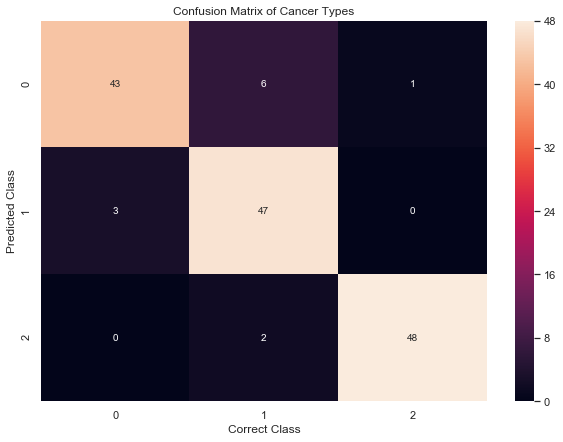

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
array = confusion_matrix(y_test2, np.round(y_hat_test_enhance))
df_cm = pd.DataFrame(array, index = [i for i in '012'],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix of Cancer Types")
sn.heatmap(df_cm, annot=True)
plt.xlabel("Correct Class")
plt.ylabel("Predicted Class")
plt.show()

**Answer:**
92% correct is not too bad all things considered. 12 incorrect out of 150 would give an average cost of $400 per patient if we misdiagnosed the 12 and used the logistic regression outright. 



**5.2 Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.**

**Answer:**
The simplest action would be to predict probabilities for each of the classes and abstain from predictions where the probability is not above a certain threshold. On the costs, abstaining 5 times is the same as getting 1 mis-diagnosis. To make a true determination, we'd also want to know how much money we save on an accurate diagnosis. If we know these 3 things then we can start adjusting our probability criteria to optimize between these 3 considerations. Also, looking at the confusion matrix above, we may be able to target our issue areas by looking at common misclassifications. For example, our biggest mistakes are between 0's and 1's, but we aren't misclassifying any 2's as 0's. So we probably should keep our cutoff the same for 2's, but 1's and 0's should likely have an abstain range. 